## KDD Cup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy.io import loadmat
import h5py
from scipy.io.arff import loadarff 
from utils.utils_gmm import *
from sklearn.datasets import load_breast_cancer
import os
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
sns.set_style('darkgrid')

SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
sns.set()

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Load Data

In [3]:
names = "duration,src_bytes,dst_bytes,hot,logged_in,num_compromised,root_shell,num_root,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate".split(",")
features = names
df = pd.read_csv("data/kdd99-unsupervised-ad.csv", names=np.append(names, "label"))
df.head(5)

,duration,src_bytes,dst_bytes,hot,logged_in,num_compromised,root_shell,num_root,num_shells,num_access_files,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,215.0,45076.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,n
1,0.0,162.0,4528.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,n
2,0.0,236.0,1228.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,n
3,0.0,233.0,2032.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,n
4,0.0,239.0,486.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,n


In [7]:
# extraxt features and target
Y = df["label"]
Y = (Y == "o").astype("int").values

X = df.values[:, :-1]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Y.shape, X_scaled.shape

((620098,), (620098, 29))

In [12]:
nr_of_outliers  = np.count_nonzero(df["label"] == "o")
print(f"Inliner: {X.shape[0]}, Outlier: {nr_of_outliers}, Outlier rate: {nr_of_outliers / X.shape[0] * 100}%")

Inliner: 620098, Outlier: 1052, Outlier rate: 0.16965060361426743%


In [29]:
NUM_EPOCHS = 15
LEARNING_RATE = 1e-3
BATCH_SIZE = 32


In [30]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [50]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=29, out_features=25)
        self.enc2 = nn.Linear(in_features=25, out_features=22)
        self.enc3 = nn.Linear(in_features=22, out_features=20)
        # decoder 
        self.dec1 = nn.Linear(in_features=20, out_features=22)
        self.dec2 = nn.Linear(in_features=22, out_features=25)
        self.dec3 = nn.Linear(in_features=25, out_features=29)
    def forward(self, x):
        x = torch.tanh(self.enc1(x))
        x = torch.tanh(self.enc2(x))
        x = torch.tanh(self.enc3(x))
        x = torch.tanh(self.dec1(x))
        x = torch.tanh(self.dec2(x))
        x = torch.sigmoid(self.dec3(x))
        return x
net = Autoencoder()
print(net)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

Autoencoder(
  (enc1): Linear(in_features=29, out_features=25, bias=True)
  (enc2): Linear(in_features=25, out_features=22, bias=True)
  (enc3): Linear(in_features=22, out_features=20, bias=True)
  (dec1): Linear(in_features=20, out_features=22, bias=True)
  (dec2): Linear(in_features=22, out_features=25, bias=True)
  (dec3): Linear(in_features=25, out_features=29, bias=True)
)


In [51]:
tensor_x = torch.Tensor(X_scaled) # transform to torch tensor

dataset = TensorDataset(tensor_x) 
trainloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
trainloader

In [52]:
from tqdm.notebook import tqdm

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    pbar = tqdm(range(NUM_EPOCHS))
    for epoch in pbar:
        running_loss = 0.0
        for data in trainloader:
            batch = data[0]
            batch = batch.to(device)
            batch = batch.view(batch.size(0), -1)
            optimizer.zero_grad()
            outputs = net(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        #print('Epoch {} of {}, Train Loss: {:.10f}'.format(
         #   epoch+1, NUM_EPOCHS, loss))
    return train_loss

  0%|          | 0/15 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

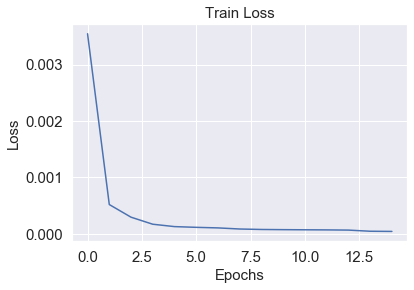

In [53]:
# get the computation device
device = get_device()
# load the neural network onto the device
net.to(device)

# train the network
net.train()
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

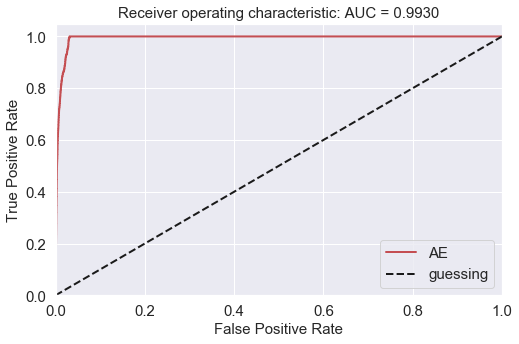

,duration,src_bytes,dst_bytes,hot,logged_in,num_compromised,root_shell,num_root,num_shells,num_access_files,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,score,label
530832,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0.18,1,0.01,0,0.99,0.107390,0
529071,0,0,0,0,0,0,0,0,0,0,...,1,0,0.01,0.05,0.01,0.01,0.99,0.99,0.095697,0
528894,0,0,0,0,0,0,0,0,0,0,...,1,0,0.02,0.24,0.02,0.01,0.98,0.99,0.094400,0
529521,0,0,0,0,0,0,0,0,0,0,...,1,0,0.01,0.12,0.01,0.01,0.99,0.99,0.088095,0
518322,0,0,0,0,0,0,0,0,0,0,...,1,0,0.11,0.16,1,0.07,0,0.93,0.082276,0


In [60]:
net.eval()

tensor_x_test = torch.Tensor(X_scaled) 

reconstructed = net(tensor_x_test).cpu().detach().numpy()
diff = ((reconstructed - X_scaled)**2)
mse = ((reconstructed - X_scaled)**2).mean(axis=1)

scored_df = pd.DataFrame(X)
scored_df.columns = df.columns[:-1]
scored_df.index = df.index 
scored_df["score"] = mse
scored_df["label"] = Y

reconstructed_df = pd.DataFrame(scaler.inverse_transform(reconstructed))
reconstructed_df.columns = df.columns[:-1]
reconstructed_df.index = df.index 
reconstructed_df["score"] = mse
reconstructed_df["label"] = Y

fpr, tpr, thresholds = metrics.roc_curve(scored_df['label'], scored_df['score'], pos_label=1)
auc = metrics.auc(fpr,tpr)

plt.figure(figsize=[8,5])
plt.plot(fpr, tpr, color='r', lw=2, label='AE')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: AUC = {0:0.4f}'.format(auc))
plt.legend(loc="lower right")
plt.show()  

sorted_df = scored_df.sort_values(by="score", ascending=False)
sorted_df.head(5)

### Calculate distances per dimension

In [61]:
diff = (np.abs((reconstructed - X_scaled)))
distances = pd.DataFrame(diff, columns=df.columns[:-1])
distances.index = df.index
distances.head(3).round(3)

,duration,src_bytes,dst_bytes,hot,logged_in,num_compromised,root_shell,num_root,num_shells,num_access_files,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,0.002,0.003,0.001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.143,0.015,0.46,0.068,0.021,0.067,0.002,0.0,0.0,0.001
1,0.0,0.002,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001,0.067,0.00,0.001,0.005,0.021,0.014,0.0,0.0,0.003
2,0.0,0.002,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003,0.064,0.00,0.002,0.003,0.014,0.008,0.0,0.0,0.002


In [62]:
outlier_idx = sorted_df[sorted_df["label"] == 1].index
outlier_idx = outlier_idx[np.argsort(outlier_idx)]

### Store Results

In [64]:
sorted_df.loc[outlier_idx].to_csv("results/ae_kdd_cup_scored.csv")
distances.loc[outlier_idx].to_csv("results/ae_kdd_cup_distances.csv")

### Examine Results

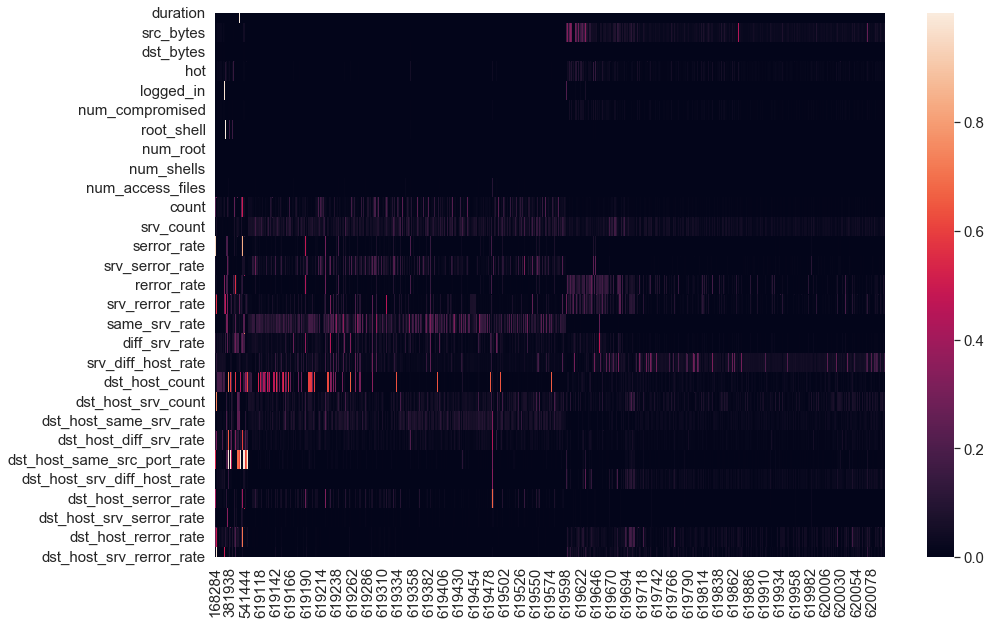

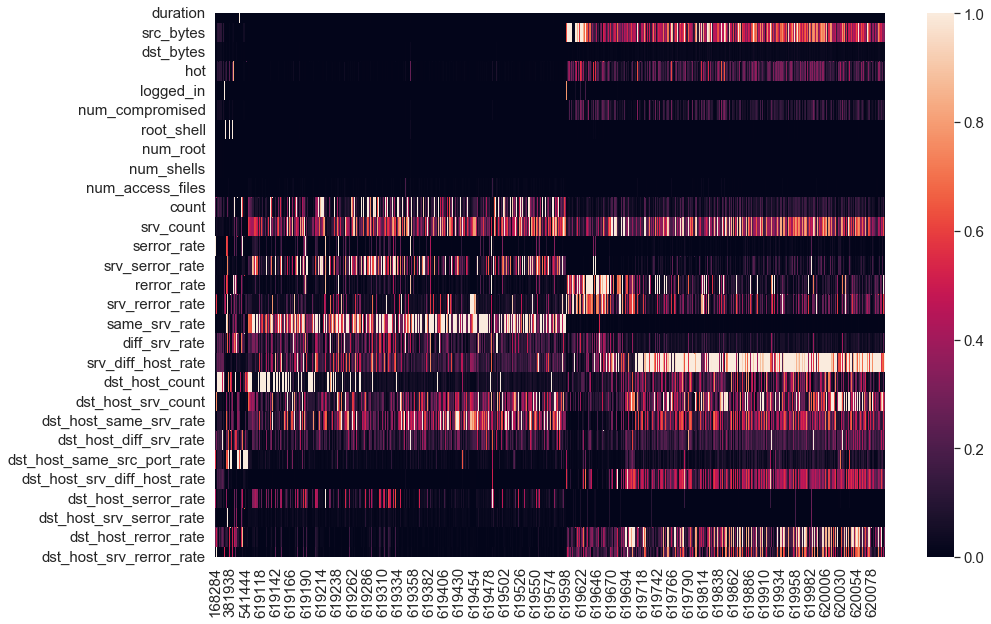

In [65]:
plt.figure(figsize=[15, 10])
sns.heatmap(distances.loc[outlier_idx].T)
plt.show()
plt.figure(figsize=[15, 10])
distances_norm = distances.loc[outlier_idx].T / np.max(distances.loc[outlier_idx].T.values, axis=0)
sns.heatmap(distances_norm)

<BarContainer object of 5 artists>

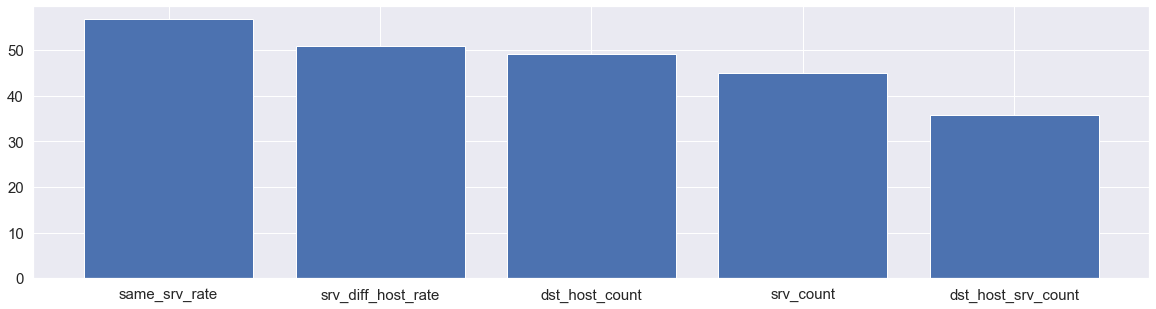

In [66]:
TOP_COLUMNS = 5
plt.figure(figsize=[20, 5])
dist_sum = distances.loc[outlier_idx].sum().sort_values(ascending=False)[:TOP_COLUMNS]
plt.bar(dist_sum.index, dist_sum.values)

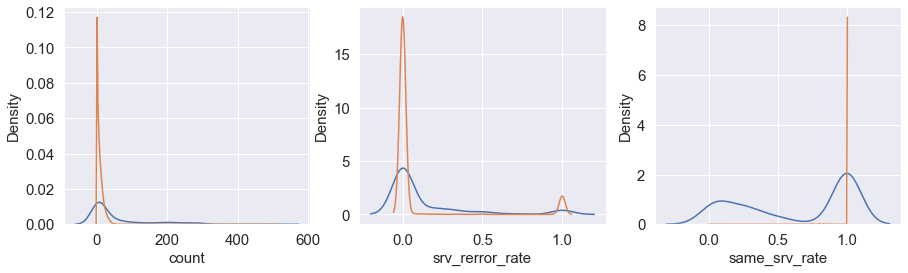

In [32]:
# plot the density estimation for the top 3 feautres for the inlier and outlier class
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, c in zip(axes, dist_sum.index[:3].values):
    sns.kdeplot(data=df[df["label"] == "o"], x=c, ax=ax)
    sns.kdeplot(data=df[df["label"] == "n"], x=c, ax=ax)

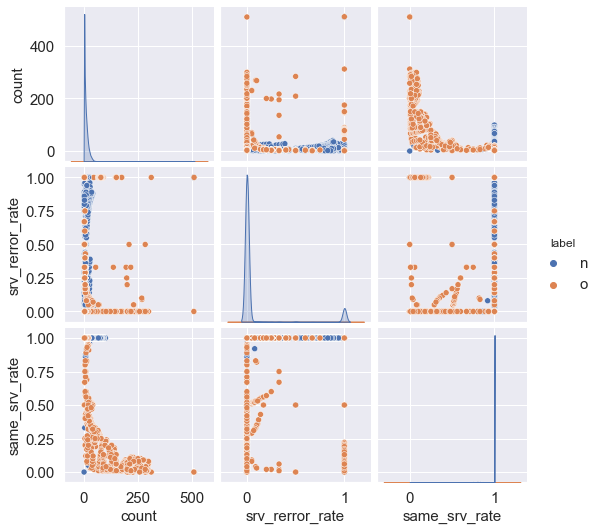

In [34]:
sns.pairplot(df, hue="label", vars=dist_sum.index[:3].values)

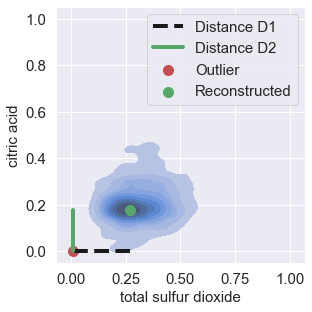

In [62]:
# analyse single outlier

IDX = 4827

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

col_1 = "total sulfur dioxide"
col_2 = "citric acid"

columns = df.columns[1:]
col_1_idx = np.argsort(columns == col_1)[-1]
col_2_idx = np.argsort(columns == col_2)[-1]

temp = pd.DataFrame(X_scaled, columns=columns, index=df.index)
sns.kdeplot(data=temp, x=col_1, y=col_2, ax=ax, fill=True)
ax.scatter(X_scaled[IDX][col_1_idx], X_scaled[IDX][col_2_idx], c="r", s=100, label="Outlier")
ax.scatter(reconstructed[IDX][col_1_idx], reconstructed[IDX][col_2_idx], c="g", s=100, label="Reconstructed")
point = X_scaled[IDX][[col_1_idx, col_2_idx]]
dist = distances.loc[IDX][[col_1, col_2]].values 
ax.plot([point[0],point[0]+dist[0]], [point[1],point[1]], c="k", lw=4, linestyle="dashed", label="Distance D1")
ax.plot([point[0],point[0]], [point[1],point[1]+dist[1]], c="g", lw=4, label="Distance D2")
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.legend(loc="upper right")
fig.tight_layout()
plt.savefig(f"images/ae_outlier_analyis_{IDX}.svg", bbox_inches="tight")
plt.show()